In [ ]:
!pip install -U sentence-transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/flowers/flowers.zip' -d '/content/flowers'

In [ ]:
import os
import torchvision.transforms as tt
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import numpy as np
import random
from PIL import Image
from sentence_transformers import SentenceTransformer

In [ ]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
df = pd.read_csv('image_desc.csv')
df2 = df.groupby('Image Name')

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
image_transform = tt.Compose([ tt.Resize(image_size), tt.CenterCrop(image_size), tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
class FlowerDescDataset(Dataset):
    def __init__(self, df2, transform = image_transform):
        self.desc_df = df2
        self.transform=transform

    def __len__(self):
        return self.desc_df.ngroups

    def __getitem__(self,index):
        img_name = list(self.desc_df.groups.keys())[index]
        img_path = '/content/flowers/jpg/' + img_name
        img = Image.open(img_path)
        # img = np.asarray(img)
        # img = torch.from_numpy(img)
        image=self.transform(img)

        descriptions = self.desc_df.get_group(img_name)
        matching_text = descriptions.iloc[random.randint(0, len(descriptions)-1), 2]

        random_row = df.sample(n=1)
        mismatching_text = random_row['Text Description'].values[0]
        while random_row['Image Name'].values[0] == img_name:
          random_row = df.sample(n=1)
          mismatching_text = random_row['Text Description'].values[0]

        return (image, matching_text, mismatching_text)

In [ ]:
dataset = FlowerDescDataset(df2)
print(len(dataset))
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last = True)

8189


In [ ]:
for image, matching_text, mismatching_text in tqdm(dl):
  # print (image, matching_text, mismatching_text)
  lst = list(matching_text)
  print(lst)
  embeddings = sentence_model.encode(lst, device = device, convert_to_tensor = True)
  print(embeddings)
  print(embeddings.size())
  break

  0%|          | 0/128 [00:00<?, ?it/s]

['the large purple cluster is made up of a whole series of small five petal purple flowers that are grouped tightly together.', 'the lush petals on this flower are dripped in water.', 'a pinwheel shaped yellow flower with a large stigma in center.', 'the petals of the flower are narrow and extremely pointy, and consist of shades of yellow, blue and orange.', 'the dark pink bell shaped flower is inverted and has petals that are soft, smooth, soft and thick', 'this flower has orange petals and sits in a pedicel that is green in color.', 'the petals of this flower are lavender and are covered in dark purple spots.', 'this flower has petals that are white and has a yellow center', 'the flower shown has orange-red petals as its main feature.', 'there are six visible petals that are an orange color with brown spots on them.', 'very odd shaped orange flower with many tiny orange petals.', 'the petals of the flower is a vibrant light green color, and the stamen is a light green color.', 'the p

# GENERATOR - DISCRIMINATOR

In [ ]:
latent_size = 256
embedding_size = 384

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, embedding_size):
        super(Generator, self).__init__()

        # self.embeddings = text_embeddings(input)

        self.main = nn.Sequential(

            # latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size + embedding_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # 3 x 64 x 64
        )

    def forward(self, noise, text):
        concat = torch.cat((noise, text), dim = 1)
        concat = concat.unsqueeze(2).unsqueeze(3)
        return self.main(concat)

generator = Generator(latent_size, embedding_size).to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(

            # 387 x 64 x 64
            #Reduction Layer
            nn.Conv2d(387, 3, kernel_size=1),

            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 8
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 x 4 x 4
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # 1 x 1 x 1
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, image, text):
        text = text.unsqueeze(2).unsqueeze(3)
        text = text.expand(-1, 384, 64, 64)
        concat = torch.cat((image, text), dim = 1)
        return self.main(concat)

discriminator = Discriminator().to(device)

In [ ]:
# latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
# fake_images = generator(latent)
# fake_labels = discriminator(fake_images)
# print(fake_images.size(), fake_labels.size())

#TRAINING

In [ ]:
def train_discriminator(opt_d, images, matching_encodings, mismatching_encodings):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # REAL IMAGE + RIGHT TEXT
    real_images = images.to(device)
    real_preds = discriminator(real_images, matching_encodings)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    sr = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, device=device)
    fake_images = generator(latent, mismatching_encodings)

    #REAL IMAGE + WRONG TEXT
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(real_images, mismatching_encodings)
    sw = F.binary_cross_entropy(fake_preds, fake_targets)
    temp_score = torch.mean(fake_preds).item()

    # FAKE IMAGE + RIGHT TEXT
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images, matching_encodings)
    sf = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = sr + sw + sf
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, temp_score, fake_score

In [ ]:
def train_generator(opt_g, matching_encodings):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, device=device)
    fake_images = generator(latent, matching_encodings)

    # Try to fool the discriminator
    preds = discriminator(fake_images, matching_encodings)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    temp_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        loss_d_lst = []
        loss_g_lst = []
        real_score_lst = []
        fake_score_lst = []
        temp_score_lst = []
        for images, matching_text, mismatching_text in tqdm(dl):
            lst1 = list(matching_text)
            matching_encodings = sentence_model.encode(lst1, device = device, convert_to_tensor = True)
            lst2 = list(mismatching_text)
            mismatching_encodings = sentence_model.encode(lst2, device = device, convert_to_tensor = True)

            # Train discriminator
            loss_d, real_score, fake_score, temp_score = train_discriminator(opt_d, images, matching_encodings, mismatching_encodings)
            loss_d_lst.append(loss_d)
            real_score_lst.append(real_score)
            fake_score_lst.append(fake_score)
            temp_score_lst.append(temp_score)

            # Train generator
            loss_g = train_generator(opt_g, matching_encodings)
            loss_g_lst.append(loss_g)

        # Record losses & scores
        loss_g = statistics.mean(loss_g_lst)
        loss_d = statistics.mean(loss_d_lst)
        real_score = statistics.mean(real_score_lst)
        fake_score = statistics.mean(fake_score_lst)
        temp_score = statistics.mean(temp_score_lst)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        temp_scores.append(temp_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.5f}, loss_d: {:.5f}, real_score: {:.5f}, fake_score: {:.5f}, temp_score: {:.5f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score, temp_score))

        # # Save generated images
        # save_samples(epoch+start_idx, fixed_latent, show=False)

        #Show Samples
        # latent = torch.randn(1, latent_size, 1, 1, device=device)
        # fake_images = generator(latent)
        # print(fake_images.size())
        # fake_images = torch.squeeze(fake_images)
        # print(fake_images.size())
        # plt.imshow(fake_images.permute(1, 2, 0).cpu().detach().numpy())
        # plt.show()

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
epochs = 128
lr = 0.0002

history = fit(epochs, lr)

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/discriminator.pth')
torch.save(generator.state_dict(), '/content/drive/MyDrive/generator.pth')

In [ ]:
def image(desc):
  latent = torch.randn(1, latent_size, device=device)
  text = []
  text.append(desc)
  encoding = sentence_model.encode(text, device = device, convert_to_tensor = True)
  fake_images = generator(latent, encoding)
  fake_images = fake_images[0]
  fake_images = torch.squeeze(fake_images)
  fake_images = (fake_images + 1)/2
  plt.imshow(fake_images.permute(1, 2, 0).cpu().detach().numpy())
  plt.show()

ENTER DESCRIPTION: lots of pink flowers


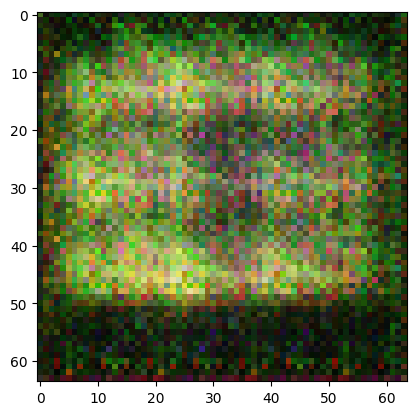

In [ ]:
desc = input("ENTER DESCRIPTION: ")
image(desc)

In [ ]:
g